# La transformée de Fourier discrète

# Une introduction

Marc Lorenzi feat MC - 9 mai 2018 -2025

In [67]:
import math
import cmath
import random
import matplotlib.pyplot as plt
from pprint import pprint
from sympy import *
#%matplotlib inline

La transformée de Fourier discrète (ou DFT pour Discrete Fourier Transform) est une opération permettant, étant donné un signal (les mathématiciens disent une fonction) périodique, d'obtenir les fréquences caractéristiques de ce signal. Pour conserver à ce notebook une longueur $L<+\infty$, j'ai choisi de ne pas parler d'un grand nombre de choses, pourtant intéressantes, essentielles, incontournables dirais-je. D'où le titre : "Une introduction".

Nous allons examiner deux algorithmes de calcul de la DFT. Le premier, naïf (vraiment ?) fonctionne bien tant que la taille des objets à manipuler reste petite. Hélas, la DFT doit souvent opérer sur des vecteurs de grandes tailles (des dizaines de milliers d'éléments). Nous introduirons dans ce but l'algorithme de la FFT (Fast Fourier Transform), qui, comme son nom l'indique, permet d'effectuer très rapidement une DFT. La FFT est sans doute l'un des algorithmes les plus utilisés sur notre planète (un peu emphatique, peut-être ?). 

## 1. Manipulation de matrices

### 1.1 Quelques fonctions utiles

Nous aurons besoin de manipuler des matrices à coefficients complexes (que nous représenterons par des listes de listes). J'ai dit "pas de boîte noire", alors nous allons définir un certain nombre de fonctions :

- `matrice(m, n)` renvoie une matrice $m\times n$ remplie de zéros.
- `taille(A)` renvoie $(m, n)$ si $A$ est une matrice $m\times n$.
- `mult_mat(A, B)` renvoie le produit des matrices $A$ et $B$.
- `mult_vec(A, X)` renvoie le produit de la matrice $A$ et de la liste $X$ identifiée à une matrice colonne.
- `conjuguee(A)` renvoie la matrice dont les coefficients sont les conjugués complexes de ceux de la matrice $A$.

__Remarque__ : dans tout le texte, nous emploierons le mot "matrice" pour désigner des listes de listes en Python. Nous emploierons le mot "vecteur" pour désigner des listes Python. Les vecteurs seront un moyen commode de représenter des matrices colonnes, plus commode que des listes de listes de taille 1, en tout cas.  

Les calculs sur les flottants renvoient des valeurs approchées. Il est toujours désagréable, lorsqu'on attend 0 comme résultat, de voir affiché à l'écran `1.0675565434567876554e-16+9.8776765454434543e-15j`. Nous allons donc également écrire quelques fonctions pour arrondir des nombres complexes, des matrices, des vecteurs.

- `roundC(z, n)` arrondit la partie réelle et la partie imaginaire de $z$ à $n$ chiffres après la virgule.
- `roundM(A, n)` applique `roundC` aux coefficients de la matrice $A$.
- `roundV(X, n)` applique `roundC` aux coefficients du vecteur $X$.

Ces fonctions ne présentent pas de difficultés particulières, et vous pouvez foncer sans dommages à la section 2 si tout cela est évident pour vous.

### 1.2 Opérations matricielles

La fonction `matrice` renvoie une matrice $m\times n$ remplie de zéros.

In [2]:
def matrice(m, n):
    A = m * [None]
    for i in range(m): A[i] = n * [0]
    return A

In [3]:
matrice(3,2)

[[0, 0], [0, 0], [0, 0]]

La fonction `taille` prend une matrice $m\times n$ en paramètre et renvoie le couple $(m, n)$. 

In [4]:
def taille(A):
    m = len(A)
    n = len(A[0])
    return (m, n)

In [5]:
taille(matrice(7, 13))

(7, 13)

La fonction `mult_mat` renvoie le produit des matrices $A$ et $B$. Il faut évidemment que les matrices aient des tailles compatibles.

In [6]:
def mult_mat(A, B):
    m, n = taille(A)
    n1, p = taille(B)
    assert n == n1
    C = matrice(m, p)
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i][j] = C[i][j] + A[i][k] * B[k][j]
    return C

In [7]:
mult_mat([[1, 2, 3], [4, 5, 6]], [[6, 5], [4, 3], [2, 1]])

[[20, 14], [56, 41]]

La fonction `mult_vec` effectue le produit de la matrice $A$ et du vecteur $X$ (une liste Python, donc), interprété comme une matrice colonne.

In [8]:
def mult_vec(A, X):
    m, n = taille(A)
    n1 = len(X)
    assert n == n1
    Y = m * [0]
    for i in range(n):
        for j in range(m):
            Y[i] = Y[i] + A[i][j] * X[j]
    return Y

In [9]:
mult_vec([[1, 2], [3, 4]], [2, 3])

[8, 18]

La conjuguée d'une matrice à coefficients dans $\mathbb C$ est la matrice des conjugués des coefficients.

In [10]:
def conjuguee(A):
    m, n = taille(A)
    B = matrice(m, n)
    for i in range(m):
        for j in range(n):
            B[i][j] = A[i][j].conjugate()
    return B

In [11]:
conjuguee([[1,1+1j],[1j, 2-1j]])

[[1, (1-1j)], [-1j, (2+1j)]]

### 1.3 Arrondis

La fonction Python `round` prend en paramètres un flottant $x$ et un entier $n$ et renvoie $x$ arrondi à $n$ chiffres après la virgule.

In [12]:
round(math.sqrt(2), 4)

1.4142

On étend cette fonction aux nombres complexes, aux matrices et aux vecteurs.

In [13]:
def roundC(z, n):
    return round(z.real, n) + round(z.imag, n) * 1j

In [14]:
roundC(1/3+1/7*1j, 3)

(0.333+0.143j)

In [15]:
def roundM(A, k):
    m, n = taille(A)
    return [[roundC(A[i][j], k) for i in range(m)] for j in range(n)]

In [16]:
def roundV(X, k):
    n = len(X)
    return [roundC(X[i], k) for i in range(n)]

## 2. Une matrice aux propriétés remarquables

### 2.1 Objectifs

__La vision "mathématicien"__ : Soient $n\ge 1$, et $a_0,a_1,\ldots,a_{n-1}\in\mathbb C$. Soit $f:\mathbb C\to\mathbb C$ la fonction polynomiale définie par $f(t)=\sum_{k=0}^{n-1}a_kt^k$. Si on me donne les $a_k$, il est évidemment facile de calculer $f(t)$ pour tout $t$. Inversement, __l'interpolation de Lagrange__ nous permet de retrouver les $a_k$ si on connaît la valeur de $f$ en $n$ nombres distincts. Le calcul par les formules "standard" nécessite un grand nombre d'opérations, et il est donc inefficace. L'idée (géniale) pour améliorer la complexité du calcul est d'__évaluer $f$ en les racines $n$-ièmes de l'unité__.

Pour tout entier $n\ge 1$, notons $\omega_n=e^{2 i\pi/n}$. $\omega_n$ engendre le groupe des racines $n$ièmes de l'unité : $\mathcal U_n=\{\omega_n^k,0\le k\le n - 1\}$. La connaissance de $f(\omega_n^k)$ pour $k=0,\ldots, n-1$ est suffisante pour calculer les $a_k$. Pourquoi les racines $n$ièmes de l'unité ? Le reste du notebook est là pour nous le faire comprendre.

__La vision "physicien"__ : soit $g(t)=\sum_{k=0}^{n-1}a_ke^{ikt}$ un signal $2\pi$-périodique. Le coefficient $a_k$ est l'amplitude de la "partie du signal" de période $\frac{2\pi}{k}$, ou, si l'on préfère, de fréquence $\frac{k}{2\pi}$. $k=1$ correspond à la "fondamentale", $k=2,3$, etc. aux "harmoniques". Comment retrouver les $a_k$ lorsqu'on dispose d'un échantillonnage du signal aux temps $t=\frac{2k\pi}{n}$, $k=0,\ldots,n-1$ ?

Ces deux visions ne sont que deux perspectives d'une même réalité puisqu'on a $g(t)=f(e^{it})$.

Nous allons tout d'abord voir qu'une simple opérations matricielle permet de passer des fréquences au signal ET du signal aux fréquences. C'est cela la DFT.

### 2.2 La matrice $W_n$

La fonction `racine_unite` renvoie $\omega_n=e^{\frac{2i\pi}{n}}$.

In [17]:
def racine_unite(n):
     return cmath.exp(2 * 1j * math.pi / n)

In [18]:
racine_unite(4)

(6.123233995736766e-17+1j)

C'est ce que je voulais dire plus haut quand je parlais de problèmes d'arrondi, parce que en réalité, $\omega_4=i$.

In [19]:
roundC(racine_unite(4), 15)

1j

Soit $W_n\in\mathcal M_n(\mathbb C)$ définie pour $0\le i,j\le n-1$ par $(W_n)_{ij}=\omega_n^{-ij}$. La matrice $W_n$ est la matrice de Vandermonde associée aux racines $n$ièmes de l'unité. Votre cours sur l'interpolation de Lagrange vous montrera que c'est bien cette matrice qui nous intéresse. Et si vous avez perdu votre cours, regardez la suite qui vous le prouvera aussi. 

In [20]:
def W(n):
    omega = racine_unite(n)
    A = matrice(n, n)
    for i in range(n):
        for j in range(n):
            A[i][j] = omega ** (-i * j)
    return A

In [62]:
print(W(4))

[[(1+0j), (1+0j), (1+0j), (1+0j)], [(1+0j), (6.123233995736766e-17-1j), (-1-1.2246467991473532e-16j), (-1.8369701987210297e-16+1j)], [(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j), (-1-3.6739403974420594e-16j)], [(1+0j), (-1.8369701987210297e-16+1j), (-1-3.6739403974420594e-16j), (5.51091059616309e-16-1j)]]


In [68]:
pprint(Matrix(roundM(W(4), 14)))

⎡1.0   1.0    1.0    1.0  ⎤
⎢                         ⎥
⎢1.0  -1.0⋅ⅈ  -1.0  1.0⋅ⅈ ⎥
⎢                         ⎥
⎢1.0   -1.0   1.0    -1.0 ⎥
⎢                         ⎥
⎣1.0  1.0⋅ⅈ   -1.0  -1.0⋅ⅈ⎦


Bon, alors, pourquoi les racines $n$ièmes de l'unicité ? Eh bien à cause du théorème ci-dessous. Interpoler, c'est inverser une matrice de Vandermonde. Et en général ce n'est pas très simple. Mais ici C'EST SIMPLE.

__Proposition__ : $\overline{W_n}W_n=nI_n$.

__Démonstration__ : Pour $0\le i,j\le n-1$, on a $(\overline{W_n}W_n)_{ij}=\sum_{k=0}^{n-1}(\overline{W_n})_{ik}(W_n)_{kj}=\sum_{k=0}^{n-1}\omega_n^{ik}\omega_n^{-kj}=\sum_{k=0}^{n-1}(\omega_n^{i-j})^{k}$. Comme $-n+1\le i - j\le n-1$, $\omega_n^{i-j}=1$ si et seulement si $i=j$. Deux cas sont donc à considérer.

- Si $i=j$, $(\overline{W_n}W_n)_{ij}=\sum_{k=0}^{n-1}1=n$.
- Si $i\ne j$, $(\overline{W_n}W_n)_{ij}=\frac{1-(\omega_n^{i-j})^{n}}{1-\omega_n^{i-j}}=0$ puisque $\omega_n^{i-j}\in\mathcal U_n$.

On a donc bien $\overline{W_n}W_n=nI_n$.

__Corollaire__ : La matrice $W_n$ est inversible et son inverse est $\frac 1 n \overline{W_n}$.

In [69]:
A = W(5)
pprint(Matrix(roundM(mult_mat(A, conjuguee(A)), 13)))

⎡5.0   0    0    0    0 ⎤
⎢                       ⎥
⎢ 0   5.0   0    0    0 ⎥
⎢                       ⎥
⎢ 0    0   5.0   0    0 ⎥
⎢                       ⎥
⎢ 0    0    0   5.0   0 ⎥
⎢                       ⎥
⎣ 0    0    0    0   5.0⎦


### 2.3 Échantillonnage

Dorénavant, nous privilégierons la vision du physicien, sans doute plus "parlante" que celle du mathématicien. Soit $f:\mathbb R\to\mathbb C$ une fonction de période $2\pi$. La fonction `sample` renvoie la liste des $f(\frac{2k\pi}{n})$ pour $0\le k\le n-1$.

In [24]:
def sample(f, n):
    return [f(2 * k * math.pi / n) for k in range(n)]

In [70]:
X = sample(lambda t: 2 * cmath.exp(1j * t) - 3 * cmath.exp(1j * 2 * t), 10)
pprint(Matrix(X))

⎡                 -1.0                 ⎤
⎢                                      ⎥
⎢0.690983005625053 - 1.67759904430051⋅ⅈ⎥
⎢                                      ⎥
⎢3.04508497187474 + 0.138757275712887⋅ⅈ⎥
⎢                                      ⎥
⎢1.80901699437495 + 3.66546878946773⋅ⅈ ⎥
⎢                                      ⎥
⎢-2.54508497187474 + 4.02874005347041⋅ⅈ⎥
⎢                                      ⎥
⎢    -5.0 + 9.79717439317883e-16⋅ⅈ     ⎥
⎢                                      ⎥
⎢-2.54508497187474 - 4.02874005347041⋅ⅈ⎥
⎢                                      ⎥
⎢1.80901699437495 - 3.66546878946773⋅ⅈ ⎥
⎢                                      ⎥
⎢3.04508497187474 - 0.138757275712889⋅ⅈ⎥
⎢                                      ⎥
⎣0.690983005625054 + 1.67759904430051⋅ⅈ⎦


Que se passe-t-il si l'on calcule le produit matriciel $W_nX$ ? Supposons que $f(t)=\sum_{j=0}^{n-1}a_je^{ijt}$, où les $a_k\in\mathbb C$. On a alors, pour $0\le k\le n-1$, $f(\frac{2k\pi}n)=\sum_{j=0}^{n-1}a_j\omega_n^{jk}$. De là,

$(W_nX)_{i1}=\sum_{k=0}^{n-1}(W_n)_{ik}X_{k1}=\sum_{k=0}^{n-1}\omega_n^{-ik}\sum_{j=0}^{n-1}a_j\omega_n^{kj}$. Inversons les sommes : $(W_nX)_{i1}=\sum_{j=0}^{n-1}a_j\sum_{k=0}^{n-1}\omega_n^{k(-i+j)}$. Comme vu un peu plus haut, toutes les sommes sur $k$ sont nulles sauf lorsque $i=j$. Ainsi, $(W_nX)_{i1}=na_i$.

__Bilan__ : un échantillonnage de $f$ suivi d'un produit par $W_n$ permet de récupérer les valeurs des coefficients $a_i$.

__Remarque__ : le calcul ci-dessus renvoie $na_i$ et pas $a_i$. On pourrait s'en débarrasser mais laissons le facteur $n$ dans un coin de notre esprit. On pourra toujours diviser par $n$ le moment venu s'il le faut.

In [71]:
Y = mult_vec(W(10), X)
pprint(Matrix(roundV(Y, 10)))

⎡  0  ⎤
⎢     ⎥
⎢20.0 ⎥
⎢     ⎥
⎢-30.0⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣  0  ⎦


L'opération que nous venons de décrire s'appelle la _transformée de Fourier discrète_.

### 2.4 Signaux réels

En général les signaux réels sont réels. Euh, enfin, je veux dire qu'une fonction qui représente un vrai signal de la vraie vie est une fonction à valeurs dans $\mathbb R$ et pas $\mathbb C$.

Que se passe-t-il exactement si on calcule la DFT d'une fonction à valeurs réelles ? Considérons pour simplifier notre discussion la fonction $f(t)=\cos kt$. On a $f(t)=\frac 1 2 e^{ikt}+\frac 1 2 e^{-ikt}$, la somme de DEUX exponentielles. Lorsqu'on échantillonne $\frac 1 2 e^{ikt}$ tout se passe comme vu plus haut. Mais que se passe-t-il lorsqu'on échantillonne $\frac 1 2 e^{-ikt}$ ? Après tout, $-k$ n'est pas un entier entre 0 et $n-1$ ... Reprenons une partie du calcul fait plus haut. Un signe moins s'y glisse sournoisement et on tombe sur la somme $\sum_{k=0}^{n-1} \omega_n^{-k(i+j)}$, qui est nulle sauf si $i+j$ est un multiple de $n$. Comme $0\le i, j\le n-1$, cela ne peut arriver que si $i+j=n$, c'est à dire $j=n-i$. Dit autrement, si on échantillonne $\cos kt$ et qu'on multiplie par $W_n$ le vecteur d'échantillonnage, on obtient DEUX coefficients non nuls, aux indices $k$ et $n-k$. Et ces coefficients sont égaux à $\frac n 2$.

In [27]:
X = sample(lambda t: math.cos(2 * t), 10)
Y = mult_vec(W(10), X)
print(roundV(Y, 10))

[0j, 0j, (5+0j), 0j, 0j, 0j, 0j, 0j, (5+0j), 0j]


__Conclusion pratique__ : si l'on veut analyser un signal réel dont les fréquences sont comprises entre 0 et $f_{max}$, il faudra faire un échantillonnage de taille au moins $2f_{max}$. Sinon, les informations relatives à des fréquences différentes vont s'additionner et seront donc perdues ! Cette constatation est un cas particulier d'un théorème de la __théorie de l'information__, appelé le théorème de Shannon.

Pour prendre un exemple concret, l'oreille humaine ne peut pas entendre de sons de fréquence supérieure à 20 KHz (à part Clark Kent et quelques autres). Si l'on veut numériser fidèlement un son, il faudra donc l'échantillonner à 40 KHz, c'est à dire stocker 40000 valeurs de l'intensité du son par seconde. C'est beaucoup. Pour un morceau de musique de 3 minutes, cela représente 7200000 valeurs. En supposant que l'on stocke chaque intensité par un flottant sur 4 octets, cela fait un fichier d'environ 30 Méga-octets. Voilà pourquoi des méthodes de compression (MP3 pour citer la plus populaire) sont utilisées pour stocker la musique ou pour la transmettre sur un réseau.

### 2.5 La DFT

La fonction de DFT fait deux lignes. Il n'y a qu'à lire (et comprendre) ce qui précède.

In [28]:
def DFT(X):
    n = len(X)
    return mult_vec(W(n), X)

Testons. Échantillonnons une fonction simple, et traçons le graphe de la DFT. Vous étiez inquiets n'est-ce pas ? Toujours aucune image :-) ...

In [29]:
X = sample(lambda x: math.sin(3 * x), 30)
print(roundV(DFT(X), 12))

[0j, 0j, 0j, -15j, (-0+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, (-0+0j), 0j, (-0+0j), (-0+0j), 0j, 0j, 0j, (-0+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 15j, 0j, (-0+0j)]


Petit souci. Le vecteur de la DFT est à coefficients complexes. On va tracer les __modules__ des coefficients, ce qui est un bon choix pour avoir une idée de leur grandeur (pléonasme : la "grandeur" d'un nombre complexe c'est son module). 

In [30]:
def plotC(X):
    plt.plot([abs(z) for z in X])
    plt.grid()
    plt.show()

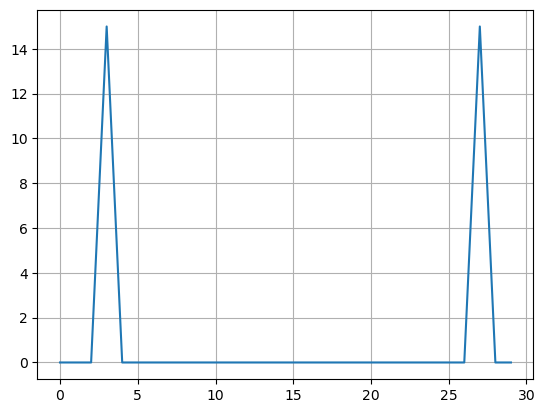

In [31]:
X = sample(lambda x: math.sin(3 * x), 30)
plotC(DFT(X))

Comme le prévoyait la théorie, il y a deux pics, un à la "fréquence" 3, l'autre à la "fréquence" 27. N'hésitez pas à expérimenter, changez la fonction, combinez des cosinus avec des fréquences différentes, etc.

__Remarque__ : Je sais, 3 et 27 ne sont pas les fréquences mais les pulsations du signal. Divisez par $2\pi$ si cela vous plonge dans le ravissement.

### 2.6 La DFT inverse

Il est évidemment immédiat d'inverser une DFT puisqu'on connaît l'inverse de la matrice $W_n$. Et n'oublions pas de diviser par $n$, qui était rangé dans un coin de notre esprit.

In [32]:
def invDFT(X):
    n = len(X)
    Y = mult_vec(conjuguee(W(n)), X)
    for k in range(n):
        Y[k] = Y[k] / n
    return Y

Allez, un petit test numérique. Composons `DFT` et `invDFT`. Cela devrait donner l'identité.

In [33]:
X = sample(lambda x: math.sin(x), 100)
X1 = invDFT(DFT(X))
err = [abs(X[i] - X1[i]) for i in range(len(X))]
print(max(err))

3.8505274739363175e-14


Tout va bien. Pas d'erreur (à $\varepsilon$ près :-))

### 2.7 Une première application : le filtrage du bruit

Lorsqu'on cherche à analyser un "vrai" signal, celui-ci est en général perturbé par un certain nombre de facteurs : erreurs de mesure, erreurs de transmission, parasites, etc. Ces perturbations, que nous appellerons "bruit", peuvent dans certains cas être vues comme des signaux de grande fréquence. Comment éliminer le bruit et retrouver un signal sans défaut ? Voici une méthode qui peut, parfois, donner des résultats probants :

1. Échantillonner le signal
2. Faire une DFT
3. Mettre à 0 les coefficients de la DFT de haute fréquence
4. Faire une DFT inverse

Évidemment, tout l'art de l'élimination consiste à apprécier ce que l'on considère comme une "haute" fréquence. Et nous sommes tout à fait conscients que :

1. On risque d'éliminer une partie du vrai signal.
2. On n'éliminera pas les composantes du bruit de basse fréquence.

Voici deux fonctions. La fonction $f$ est une très jolie fonction. La fonction $f_1$ est une perturbation de la fonction $f$.

In [34]:
def f(x): return 3 * math.sin(x) + 2 * math.cos(3 * x) - math.sin(6 * x)
def f1(x): return f(x) + 0.5 * random.random()

En noir le graphe de $f$, en rouge celui de $f_1$.

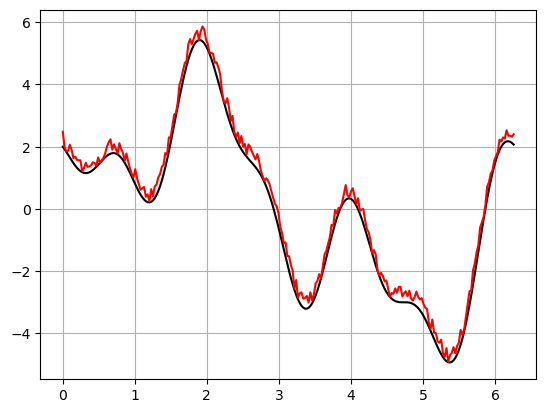

In [35]:
n = 256
xs = [2 * k * math.pi / n for k in range(n)]
ys = sample(f, n)
zs = sample(f1, n)
plt.plot(xs, ys, 'k')
plt.plot(xs, zs, 'r')
plt.grid()
plt.show()

Éliminons les hautes fréquences.

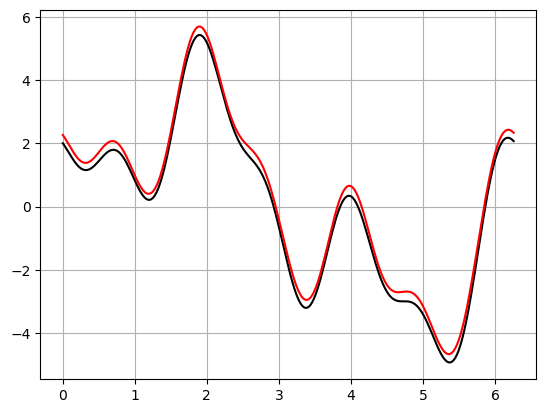

In [36]:
n = 256
xs = [2 * k * math.pi / n for k in range(n)]
ys = sample(f, n)
X = sample(f1, n)
Y = DFT(X)
for k in range(10, n - 10): Y[k] = 0
X1 = [z.real for z in invDFT(Y)]
plt.plot(xs, ys, 'k')
plt.plot(xs, X1, 'r')
plt.grid()
plt.show()

Le signal "débruité" est joli mais il n'est pas exactement égal au signal espéré. Moralité, le bruit ce n'est pas que du signal de haute fréquence. On s'en contentera.

### 2.8 Un inconvénient rédhibitoire de la DFT

Quel est le temps de calcul d'une DFT ? Facile, on multiplie une matrice $n\times n$ par une matrice colonne de taille $n$. On a donc une complexité en $O(n^2)$. Essayez pour voir de lancer dans une des cellules ci-dessus la DFT d'un vecteur de taille 1000. On commence à attendre. Un peu, pas beaucoup. Puis prenez un vecteur de taille 3000. Vous attendrez $3^2\simeq 10$ fois plus, c'est à dire beaucoup. Désolé pour le $3^2=10$, je n'ai pas pu me retenir.

Pour des petites valeurs de $n$ (dans l'exemple de l'élimination du bruit, $n=256$), cela ne pose pas de problème. En revanche, le temps de calcul devient prohibitif pour des applications réelles de la DFT. Pour reprendre un exemple vu plus haut, les sons audibles par une oreille humaine ont des fréquences s'étendant jusqu'à environ 20000 Hz. Pour analyser correctement un son, il faudra donc l'échantillonner à 40000 Hz. Mais $40000^2$, cela fait environ 2 milliards ... C'est faisable en quelques secondes, mais le problème c'est que les artefacts faisant du traitement du son ont besoin de faire des DFT en temps réel. Bref, c'est impossible avec notre algorithme naïf. Il faut trouver mieux.

__Remarque__ : c'est quoi un artefact faisant du traitement du son ? En fait, de nos jours, cela englobe tout appareillage ayant quelque chose à voir avec le son : un ordinateur, un lecteur MP3, une télévision, une enceinte Bluetooth, un téléphone, une radio, etc. 

Seriez-vous prêts à attendre 5 secondes pour chaque note de musique lorsque vous écoutez un morceau :-) ?

# 2. La FFT (Fast Fourier Transform)

### 2.1 Genèse

L'algorithme que nous allons décrire permet le calcul de la DFT d'un vecteur de taille $n$ en $O(n\log n)$ opérations. Pour reprendre l'exemple du son, une centaine de milliers d'opérations pour la FFT, au lieu de 2 milliards pour le DFT naïve. 10000 fois plus rapide. 

L'algorithme a été (re-)découvert au début des années 1960 par John Tukey, mathématicien à Princeton, et John Cooley qui travaillait pour IBM. Tukey n'était apparemment pas très enclin à publier son algorithme, ce fut Cooley qui prit l'initiative en 1965. Pourquoi Tukey ne voulait-il pas publier ? Entre autres, il pensait que ce n'était pas très intéressant et que d'autres gens avant lui avaient sûrement déjà eu la même idée. Sur le premier point il avait tort : la FFT est sans doute l'un des algorithmes les plus universellement utilisés de nos jours, dans tous les domaines des sciences. Sur le second point il avait parfaitement raison : des ingénieurs britanniques avaient déjà utilisé la FFT dans des calculs à la main à la fin des années 1930 :-).

Ne jetons pas la pierre à Tukey, dans les années 1960 on pensait que les algorithmes n'étaient pas des objets vraiment dignes d'être étudiés ou admirés. On a changé d'avis depuis. quoique en fait, il reste des gens qui pensent encore comme dans les années 60 :-). 

__PS__ : Redde Gaussi quae sunt Gaussis : les idées de la FFT apparaissent déjà dans des travaux de Gauss datant de 1805. La FFT a d'ailleurs été appelée le 1001ème algorithme de Gauss :-).

### 2.2 L'algorithme récursif

__HYPOTHÈSE__ : Dorénavant, tous les tableaux (vecteurs, matrices) que nous considérerons auront une taille qui est une puissance de 2. C'est restrictif et il y a des moyens de lever cette restriction, mais faisons simple pour commencer.

Le principe de l'algorithme est le suivant. Soit à effectuer la FFT d'un vecteur $X$. Si $X$ est de taille 1, c'est pas trop dur. Sinon :

1. Scinder $X$ en deux moitiés $X_1$ et $X_2$, constituées respectivement des éléments de $X$ d'indices pairs et des éléments de $X$ d'indices impairs.
2. Effectuer récursivement les FFT $Y_1$ et $Y_2$ de $X_1$ et $X_2$.
3. __Combiner__ $Y_1$ et $Y_2$ pour obtenir la FFT $Y$ du vecteur $X$ original.

Un algorithme qui divise les objets à traiter, qui traite les sous-objets puis les recombine, est appelé un algorithme __diviser pour régner__ (Divide and Conquer).

In [37]:
def FFT(X):
    n = len(X)
    if n == 1: return [X[0]]
    else:
        w = cmath.exp(-2 * 1j * cmath.pi / n)
        X1, X2 = pairs(X), impairs(X)
        Y1, Y2 = FFT(X1), FFT(X2)
        return combiner(Y1, Y2, w)

Pour `pairs` et `ìmpairs`, aucun souci bien entendu.

In [38]:
def pairs(X): return [X[i] for i in range(len(X)) if i % 2 == 0]
def impairs(X): return [X[i] for i in range(len(X)) if i % 2 == 1]

In [39]:
print(pairs([6,1,7,4]))
print(impairs([6,1,7,3]))

[6, 7]
[1, 3]


__Remarque__ : le lecteur potentiellement traumatisé par les calculs qui suivent peut les sauter en première lecture (mais pas en deuxième).

Évidemment, le génie de l'algorithme réside dans la fonction `combiner`. Un peu de maths vont être nécessaires. Avec les notations du paragraphe 2.3, on a pour $0\le i\le n - 1$, $(W_nX)_{i1}=\sum_{k=0}^{n-1}(W_n)_{ik}X_{k1}$. Rappelons que $n$ est une puissance de 2 différente de 1, donc $n$ est pair. Séparons dans la somme les termes d'indices pairs et d'indices impairs :

$(W_nX)_{i1}=\sum_{k=0}^{n/2-1}(W_n)_{i,2k}X_{2k,1}+\sum_{k=0}^{n/2-1}(W_n)_{i,2k+1}X_{2k+1,1}=\sum_{k=0}^{n/2-1}(W_n)_{i,2k}X'_{k1}+\sum_{k=0}^{n/2-1}(W_n)_{i,2k+1}X''_{k1}$ où $X'$ et $X''$ sont les sous vecteurs de $X$ formés des éléments d'indices pairs et impairs respectivement.

Remarquons maintenant que $(W_n)_{i,2k}=\omega_n^{-2ik}=(\omega_n^2)^{-ik}=\omega_{n/2}^{-ik}$. Comprenez bien cela, c'est la clé !!! Et $(W_n)_{i,2k+1}=\omega_n^{-i(2k+1)}=\omega_n\omega_{n/2}^{-ik}$. Deux cas sont à considérer.

- Si $i\le\frac n 2 -1$, alors $(W_n)_{i,2k}=(W_{n/2})_{ik}$ et $(W_n)_{i,2k+1}=\omega_n^i(W_{n/2})_{ik}$. Ainsi, $(W_nX)_{i1}=\sum_{k=0}^{n/2-1}(W_{n/2})_{ik}X'_{k1}+\omega_n^i\sum_{k=0}^{n/2-1}(W_{n/2})_{ik}X''_{k1}=Y'_{i1}+\omega_n^i Y''_{i1}$ où $Y'$ et $Y''$ sont les DFT de $X'$ et $X''$.

- Si $i\ge\frac n 2$, posons $i=\frac n 2 + j$. On a alors $(W_n)_{n/2+j,2k}=(W_{n/2})_{jk}$ et $(W_n)_{n/2+j,2k+1}=-\omega_n^j(W_{n/2})_{jk}$. On laisse le soin au lecteur (s'il en reste un) de vérifier ces deux dernières égalités. Ainsi, $(W_nX)_{i1}=\sum_{k=0}^{n/2-1}(W_{n/2})_{jk}X'_{k1}-\omega_n^j\sum_{k=0}^{n/2-1}(W_{n/2})_{jk}X''_{k1}=Y'_{j1}-\omega_n^j Y''_{j1}$.



__En bref__ : Si on sait faire une DFT pour un vecteur de taille $\frac n 2$, alors on sait faire une DFT pour un vecteur de taille $n$. Comme on sait faire pour $n=1$, on sait faire pour tous les vecteurs dont la taille est une puissance de 2. 

On en déduit la fonction `combiner`.

In [40]:
def combiner(Y1, Y2, w):
    assert len(Y1) == len(Y2)
    n = len(Y1)
    pw = [w ** i for i in range(n)]
    U = [Y1[i] + pw[i] * Y2[i] for i in range(n)]
    V = [Y1[j] - pw[j] * Y2[j] for j in range(n)]
    return U + V

Testons.

In [41]:
FFT([random.random() for k in range(16)])

[(8.3572958167499+0j),
 (2.0567106083939497+0.8777431763664106j),
 (0.7994745554075772+0.28489355167186864j),
 (-0.47232032517576433+0.7394419829540722j),
 (1.2241237274422674+0.007256763133843824j),
 (-1.0128110320421988-0.11892943498953057j),
 (-0.815221763267566+0.24561369220264734j),
 (-0.3375772133887268+0.721472615101494j),
 (3.2848100415310038+0j),
 (-0.33757721338872726-0.7214726151014937j),
 (-0.8152217632675661-0.245613692202647j),
 (-1.012811032042199+0.11892943498953068j),
 (1.2241237274422674-0.007256763133843824j),
 (-0.4723203251757642-0.7394419829540723j),
 (0.7994745554075771-0.28489355167186897j),
 (2.0567106083939497-0.8777431763664109j)]

Eu oui bon c'est un exemple débile, ça renvoie des nombres ... Allez, un exemple plus sérieux.

In [42]:
X = sample(lambda x: 2 * math.sin(2 * x) - 6 * math.cos(5 * x), 256)

In [43]:
Y1 = DFT(X)
Y2 = FFT(X)

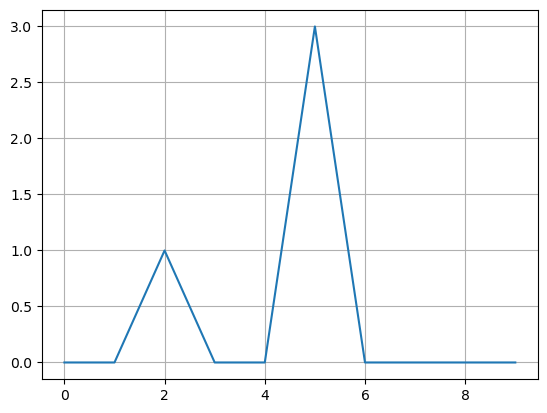

In [44]:
plt.plot([abs(y) / 256 for y in Y2][:10])
plt.grid()

In [45]:
print([roundC(abs(Y2[i] - Y1[i]), 10) for i in range(len(Y1))])

[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j,

DFT et FFT donnent le même résultat, ce qui est préférable vu que la FFT est là pour calculer vite la DFT ...

### 2.3 Optimisation de la FFT

Telle que nous l'avons écrite, la FFT possède un gros avantage et un gros inconvénient :

- Son code est très lisible, ce qui est un avantage pédagogiquement indéniable
- La fonction fait beaucoup de recopies de données, ce qui est un inconvénient matériellement indéniable pour du code qui doit s'exécuter "en temps réel".

On peut améliorer tout cela. Vous pouvez sauter ce paragraphe si vous n'êtes pas un adepte de l'algorithmique pure et dure. Acceptez simplement le code de la fonction `iterFFT` que nous allons écrire.

#### 2.3.1 L'idée

LE point casse-pieds de la FFT est qu'il faut scinder les vecteurs en deux moitiés qui contiennent chacune un élément sur deux du vecteur. Ce serait quand même plus simple si on pouvait juste prendre la première (les éléments de petits indices) et la deuxième moitié (les éléments de grands indices). Peut-être que si on mélangeait de façon extrêmement astucieuse les éléments avant de faire notre FFT, on pourrait effectivement couper juste en deux au milieu ... regardons sur un exemple.

Prenons un vecteur $X$ de taille 8. Voyons comment les différents appels successifs de la FFT découpent en petits morceaux le vecteur $X$.

Les appels récursifs du premier "niveau" se font sur les sous-vecteurs $[x_0,x_2,x_4,x_6]$ et $[x_1,x_3,x_5,x_7]$. Retenons cela sous la forme$(1, <x_0,x_2,x_4,x_6, x_1,x_3,x_5,x_7>)$.

Au second niveau, des mélanges se font sur chaque demi-tableau. Résultat : $(2, <x_0,x_4,x_2,x_6, x_1,x_5,x_3,x_7>)$.

Le troisième "niveau" de récursivité scinde des vecteurs de taille 2 en 2 vecteurs de taille 1 mais ne change rien à l'ordre des objets. Résultat : $(3, <x_0,x_4,x_2,x_6, x_1,x_5,x_3,x_7>)$. 

Écrivons maintenant les indices $(0,4,2,6,1,5,3,7)$ en base 2 sur 3 bits ($2^3=8$). On obtient $(000,100,010,110,001,101,011,111)$. Bon, et alors ? Renversons les bits, écrivons ces nombres dans le mauvais sens : $(000,001,010,011,100,101,110,111)$. On a compris : 

__PRINCIPE : le bon sens c'est le mauvais sens.__

Pour ne pas lasser le lecteur je ne prouverai pas que cette propriété est vraie dans le cas général. Cela se fait par récurrence forte sur $n$. Tout cela suggère un algorithme __itératif__ pour calculer la FFT d'un vecteur $X$ :

1. Réordonner les éléments de $X$ en les classant par "indices écrits à l'envers en base 2" croissants.
2. Combiner $[x_0]$ avec $[x_1]$, $[x_2]$ avec $[x_3]$, etc.
3. Combiner $[x_0,x_1]$ avec $[x_2,x_3]$, $[x_4,x_5]$ avec $[x_6,x_7]$, etc. (enfin les nouveaux $x_i$, parce qu'ils ont changé après l'étape 1).
4. Combiner les sous-vecteurs de tailles 4, puis 8, puis 16, etc.

L'algorithme récursif `FFT` est la vision "d'en haut" de la FFT. Supposant effectuées les FFT pour les vecteurs de taille $\frac n 2$ il les combine pour effectuer la FFT d'un vecteur de taille $n$. L'algorithme itératif, lui, est une vision "d'en bas" de la FFT. Il combine les vecteurs de taille 1, puis 2, puis 4, etc. Ceci n'est possible que grâce à la découverte de l'ordre magique des bits inversés.  

On se lance.

#### 2.3.2 Renverser les bits d'un entier

La fonction `revbits` renverse les bits de l'entier $n$, supposé être un entier sur $k$ bits, et renvoie l'entier $m$ correspondant.

In [46]:
def revbits(n, k):
    m = 0
    for i in range(k):
        m = 2 * m + n % 2
        n = n // 2
    return m

In [47]:
revbits(7,4)

14

#### 2.3.3 Le logarithme en base 2

La fonction `log2` prend en paramètre un entier $n$ supposé être une puissance de 2 ($n=2^p$) et renvoie l'entier $p$.

In [48]:
def log2(n):
    p = 0
    while n > 1:
        p = p + 1
        n = n // 2
    return p

In [49]:
log2(32)

5

#### 2.3.4 Le mélange

La fonction `shuffle` effectue le mélange du tableau $X$. Elle renvoie un tableau $X_1$ tout prêt pour une FFT 100% itérative.

In [50]:
def shuffle(X):
    n = len(X)
    k = log2(n)
    X1 = n * [0]
    for i in range(n):
        X1[revbits(i, k)] = X[i]
    return X1

In [51]:
shuffle(range(8))

[0, 4, 2, 6, 1, 5, 3, 7]

#### 2.3.4 La FFT, version itérative

Et enfin, la fonction `iterFFT` qui fait exactement la même chose que FFT, avec une complexité du même ordre de grandeur, mais sans déplacements de données (à part la création du vecteur $X_1$). Je ne commenterai pas son code.

In [52]:
def iterFFT(X):
    n = len(X)
    X1 = shuffle(X)
    m = 2
    while m <= n:
        omega = racine_unite(m)
        for k in range(0, n, m):
            w = 1
            for j in range(m // 2):
                t = w * X1[k + j + m // 2]
                u = X1[k + j]
                X1[k + j] = u + t
                X1[k + j + m // 2] = u - t
                w = w * omega
        m = m * 2
    return X1

On teste.

In [53]:
X = sample(lambda x: 3 * math.cos(x) - 2 * math.cos(4*x), 16)
Y = FFT(X)
print(Y)

[(1.021405182655144e-14+0j), (24.000000000000007+4.218847493575595e-15j), (-9.420554752102644e-16+3.324132690990998e-15j), (-4.778934881105427e-16-5.209902182330876e-17j), (-16+8.881784197001252e-15j), (-1.1604610293826104e-15+1.8545511779937424e-16j), (9.420554752102655e-16+4.2123111106911224e-15j), (-5.329070518200751e-15+1.1324274851176597e-14j), (-1.021405182655144e-14+0j), (-5.329070518200751e-15-8.215650382226158e-15j), (9.420554752102644e-16-4.212311110691123e-15j), (-1.2984633512897079e-15-3.9199018802675383e-16j), (-16-8.881784197001252e-15j), (1.1604610293826104e-15+1.1468125117508136e-15j), (-9.420554752102655e-16-3.324132690990997e-15j), (24.000000000000007-8.215650382226158e-15j)]


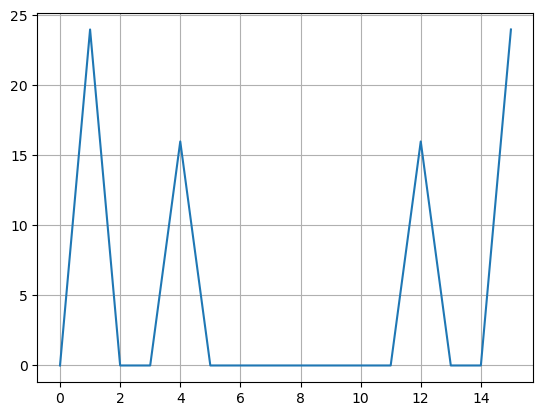

In [54]:
plotC(Y)

Sur ma machine, `iterFFT` est environ 20% plus rapide que `FFT`. Reprenez l'exemple ci-dessus avec $n=2^{20}$ au lieu de 16 (chez moi, 20 secondes pour `iterFFT` et 27 secondes pour `FFT`). C'est un souci connu : écrire une fonction de FFT vraiment efficace n'est pas facile.

La bibliothèque C standard plus utilisée pour faire des FFT est la bibliothèque `fftw` (Fastest Fourier Transform in the West). Allez faire un tour sur le site `fftw.org`, juste pour voir. 

## 3. Un exemple de la vraie vie : analyse d'un son

Nous allons analyser un "vrai" son. Enfin presque vrai, parce que mon fournisseur d'accès à Internet ne me permet pas de mettre un vrai piano sur mon site Web. Le fichier `domisol.txt` contient un son d'une seconde échantillonné à 32768 Hz. Il s'agit du son émis par un piano jouant les notes do 3 (262 Hz), mi 3 (330 Hz) et sol 3 (392 Hz). Le concepteur de ce notebook a préparé le fichier son pour que tout se passe bien :

- nombre d'échantillons puissance de 2
- export du fichier (`.wav` à l'origine) vers un fichier `.txt` contenant les amplitudes du son tous les $\frac{1}{32768}$ ièmes de seconde, plus facilement lisible avec Python.

Le logiciel utilisé (__Audacity__ en l'occurrence) affirme que l'on peut sélectionner la durée du son au $\frac 1 {1000}$ème de seconde près. Cela dit, quelques Hertz d'erreur sur nos résultats ne devront pas être pour nous une source d'angoisse. Enfin je ne crois pas. Si ? Vous pensez ? Aïe aïe aïe, j'abandooonne ...

Lisons tout d'abord le fichier et stockons le tout dans un vecteur $X$.

In [55]:
f = open('domisol.txt', 'r')
n = 32768
X = n * [0]
for k in range(n):
    X[k] = float(f.readline().split()[0])
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'domisol.txt'

Voici la "forme" du son. Évidemment on ne voit pas bien les notes. C'est un mi dièse ou un fa bémol :-) ?

In [56]:
plt.plot(X)
plt.grid()

La FFT est notre amie ... Effectuons une FFT du vecteur $X$. Le résultat est un vecteur $Y$ contenant, pour chaque fréquence, le "poids" de cette fréquence dans le son.

In [57]:
Y = iterFFT(X)

Vous avez remarqué que la FFT mérite bien son nom de __Fast__ ? Zéro seconde. Avec une DFT naïve on serait encore en train d'attendre. Traçons entre 0 et 1000 Hz (rien ne vous empêche de tracer ailleurs !).

In [58]:
plotC(Y[0:1000])

Voici la liste des fréquences les plus représentatives du son, triées par intensité décroissante ...

In [59]:
U = [(i, abs(Y[i])) for i in range(16384) if abs(Y[i])> 500]
U.sort(key=lambda x: x[1], reverse=True)
print(U[:100])

Discutons des pics par ordre décroissant de leur hauteur, en laissant tomber les pics "fantômes" (392 et 393 Hz, par exemple) ... de nombreuses raisons à ces fantômes (serait-ce ma faute ? Dois-je refaire tous mes calculs ??), l'une d'entre elles étant que les fréquences du signal n'ont aucune raison d'être des entiers. Une autre raison ? Faites un zoom entre 250 Hz et 280 Hz et vous comprendrez. Les pics sont pointus, mais pas archi-pointus.

- Le pic le plus élevé se situe à environ 262 Hz. Il s'agit de la note DO 3.
- Le second pic se situe à environ 392 Hz. C'est un SOL 3.
- Nous trouvons ensuite un pic à environ 524 = 2 x 262 Hz. Il s'agit d'un DO 4, une octave au-dessus du premier DO : c'est une _harmonique_.
- Où est le MI 3 ? Cherchez la fréquence 330 Hz. Et regardez aussi ses multiples, 660 (MI 4), 990 (MI 5) !

## 4. What Else ?

Ci-dessous quelques suggestions et compléments pour une étude plus approfondie.

### 4.1 Le problème de l'arrondi

Les calculs de FFT se font en flottants. Pour certaines applications c'est inacceptable. Il est possible, au lieu de prendre une racine $n$ième de l'unité dans $\mathbb C$, d'en prendre une dans un __corps fini__ voire un __anneau fini__ judicieusement choisi. L'étude de cette possibilité dépasse totalement le cadre du notebook.

### 4.2 Le problème de la puissance de 2

Comment faire si on veut effectuer une FFT sur un vecteur dont la taille n'est pas une puissance de 2 ? Le nombre de méthodes est au moins égal à 2, tout dépend de ce que l'on veut faire du résultat.

1. Compléter le vecteur avec des zéros pour lui donner une taille qui est une puissance de 2. Pour certaines applications cela convient. En revanche, en analyse du signal ce n'est pas une bonne idée : cela introduit des signaux factices de haute fréquence à l'intérieur du signal à analyser. Il vaut mieux dans ce cas utiliser la méthode 2.

2. On ajoute des cases au tableau pour lui donner une taille "puissance de 2", mais on remplit ces cases par une technique de miroir. Si $X$ est de taille $n$ et $n'$ est la plus petite puissance de 2 supérieure à $n$, on pose $x_{n+j}=x_{n-j-2}$ pour $j=0,1, \ldots,n'-n-1$.

### 4.3 Produit rapide de polynômes 

Soient $P=\sum_{k=0}^{n-1}a_k X^k$ et $Q=\sum_{k=0}^{n-1}b_k X^k$. Comment calculer très très très efficacement les coefficients de $PQ$ ?

1. On échantillonne $P$ et $Q$ à la fréquence $2n$. On multiplie les vecteurs obtenus, ce qui nous donne un échantillonnage $X$ de $PQ$. Tout cela se fait en temps $O(n)$. 

2. On effectue une FFT de $X$. Cela prend un temps en $O(n\log n)$. Cela nous donne les coefficients de $PQ$.

On dispose ainsi d'un algorithme permettant de multiplier $P$ et $Q$ en temps $O(n\log n)$. À peine plus que pour une addition.

__Remarque__ : nous avons justement ici un exemple de problème où des erreurs d'arrondis sont inacceptables. Imaginez des polynômes à coefficients entiers, avec une réponse à coefficients complexes à 16 chiffres après la virgule, pas tous exacts ... c'est là que les idées du paragraphe 4.1 peuvent être mises à profit. 

### 4.4 Produit rapide d'entiers

Un entier cela ressemble beaucoup à un polynôme : pensez à l'écriture en base $p$, ce n'est finalement qu'un polynôme en $p$. L'algorithme de produit des polynômes peut être adapté pour effectuer des produits d'entiers. Il s'agit de l'algorithme de Schönhage et Strassen. Sa complexité, pour multiplier deux entiers sur $n$ bits, est en $O(n\log n\log\log n)$. Au risque de me répéter, à peine plus que pour les ajouter.

Attention, cette adaptation est tout sauf triviale. À l'inverse du produit de polynômes, quand on multiplie des entiers il y a des retenues :-).

### 4.5 Parallélisme

Vous avez peut être remarqué que $O(n\log n)$ c'est super, mais que ce n'est pas comme cela que l'on peut vraiment espérer faire de la FFT en temps réel.

L'algorithme de la FFT se prête bien à la __parallélisation__. Lorsqu'on coupe un vecteur en deux moitiés, les FFT sur les deux moitiés peuvent être effectuées simultanément si l'on dispose d'un système adapté. La recombinaison des deux moitiés peut également être faite en parallèle en temps constant. Il existe ainsi des circuits numériques entièrement dédiés à des calculs de FFT. Quel est le temps de calcul d'une FFT pour un tel circuit ? Appelons $T(n)$ le temps nécessaire au calcul de la FFT d'un vecteur de taille $n$. Dans notre algorithme Python, on a $T(n)=2T(\frac n 2) + O(n)$. Mais si on dispose d'un circuit (ordinateur, machine, processeur, etc.) effectuant les calculs en parallèle, alors $T(n)=T(\frac n 2) + O(1)$. Magie du parallélisme ! Ceci nous donne (admis) :

$$T(n)=O(\log n)$$

C'est à dire, à toutes fins utiles, un temps quasi-constant. Nous y sommes, __le temps réel c'est l'instantanéité__.

__Exercice__ : Prouver l'affirmation ci-dessus lorsque $n$ est une puissance de 2. 

### 4.6, 4.7, ... , 4.$\infty$ ?

La liste des applications de la FFT est encore longue. Après en avoir examiné zéro pourcent, arrêtons nous :-).